
<H1 style="color: #581845; text-aling: center; font-size: 40px; ">Chapter 4. Tides, Rotation and Shape </H1>

<H1 style="color: black; text-aling: center; font-size: 20px; ">Action by Sofía Arboleda-Bolívar </H1>

<style>
        p {
            text-align: justify; line-height: 1.5;
        }
</style>

<p>In this notebook we will present the theory for tidal dynamics and its implications in shape and rotation of celestial bodies. Tides have been historically conceptualized and even explained in aboriginal myths. In our relationship with Earth and ocean it has been essential to understand the cycles that we experience to take advantage and also to take care of them. Altough the Ancient Greeks and Romans weren’t particularly concerned with the tides at all, in the late 10th century, the Arabs had already begun to relate the timing of the tides to the cycles of the moon.
However a scientific explanation for the tidal phenomenon had to wait for Sir Isaac
Newton and his universal theory of gravitation, published in 1687. The gravitational
theory became established as the basis for all tidal science. Details of the tides at any
given place are governed by the responses of the ocean to the gravitational forces.

This is an attempt to give an easier/fun comprehenssion of the chapter 4 of Murray & Dermott's Solar System Dynamics book. </p>

👉 😭 For details on the theory please refer directly to the book:
> Murray, C. D., & Dermott, S. F. (2000). Solar System Dynamics. Cambridge University Press.

In [1]:
#"""
!pip3 install --upgrade -q pip
!pip3 install -q pymcel
!pip3 install -q celluloid
!pip3 install -q spiceypy
!pip3 install -q astroquery 
!pip3 install -q geopandas
!pip -q install plotly
!pip -q install sympy
!pip -q install scipy
!pip -q install rebound
!pip -q install reboundx
!pip -q install seaborn
#"""

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 42.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.9/887.9 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 49.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 65.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.4/295.4 kB 6.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [80]:
import sympy as sym
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Markdown, HTML
import astropy 
from astropy import constants as const
from astropy import units as u
import spiceypy as spy
from astroquery.jplhorizons import Horizons
import datetime
from astropy.time import Time
import geopandas as gpd
import pandas as pd
import plotly.graph_objs as go
from scipy.special import sph_harm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import requests
from bs4 import BeautifulSoup

The functions used in this notebook are imported from the alternative notebook *Functions* imported bellow:

In [60]:
%run Functions.ipynb

<H1 style="color: black; text-aling: center; font-size: 15px; ">Constants </H1>

In [135]:
R_earth = float(const.R_earth.value) #Earth's radius
G = float(const.G.value)
g = float(const.g0.value)
au = float(const.au.value)
rho_earth = 5.51e3 #Earth density

m_earth = float(const.M_earth.value)
m_moon = 7.342e22 # Moon mass
a_em = 384400e3 # Mean Earth-Moon distance
m_sun = float(const.M_sun.value)
m_jup = float(const.M_jup.value)

1.8981245973360505e+27

### 4.1 Tidal Bulge 


Derivation of potentials from interaction between a planet and a satellite

Given the potential on a point P on the surface of a planet due to a satellite:

$V = -G \frac{m_s}{\triangle}$

<img src="Figures&plots/img_3.png" />

With $\triangle = a\left[ 1 - 2\left(\frac{R_p}{a}\right)cos(\Psi) + \left(\frac{R_p}{a}\right)^2\right]^{1/2}$

And since $R_p/a << 1$, $\triangle$ can be expaned binomially. However, we can consider the polynomial expansion in taylor series using sympy:

In [63]:
#Define x as the Rp/a ratio to expand around it
x, psi = sym.symbols('x, Psi') 

# Define the expression (here we use a negative exponential 
    #due to the position of the polynomial in the potential formula).

expr = (1-2*x*sym.cos(psi)+ x**2 )**(-1/2)

#Perform of Taylor series expansion
taylor_series = sym.series(expr, x, n=3)

display(Markdown('The corresponding expansion is'))
display(taylor_series)


The corresponding expansion is

1 + 1.0*x*cos(Psi) + x**2*(1.5*cos(Psi)**2 - 0.5) + O(x**3)

Now you can see that the potential is given by:
$V=-\mathcal{G} \frac{m_{\mathrm{s}}}{a}\left[1+\left(\frac{R_{\mathrm{p}}}{a}\right) \cos \psi+\left(\frac{R_{\mathrm{p}}}{a}\right)^2 \frac{1}{2}\left(3 \cos ^2 \psi-1\right)+\cdots\right]$

Since the potential can be divided in those first three terms as $V_1, V_2, V_3$, we can look at the contribution of each one of them in the total potential. For that, let's use Earth-Moon system data:


In [64]:
x_s = np.linspace(0, 2*np.pi)

#Potential components
V_1 = np.array([-G*(m_moon/a_em) for i in range(len(x_s))]) 
V_2 = V2(x_s, V_1, R_earth, a_em)
V_3 = V3(x_s, V_1, R_earth, a_em)
V_Tot = V_tot(V_1, V_2, V_3)

#serie_truncada = taylor_series.removeO() #Remove the higher order factor from the taylor series
#V = sym.lambdify((psi, x), serie_truncada,'numpy') #Lambdification of function in terms of psi and x

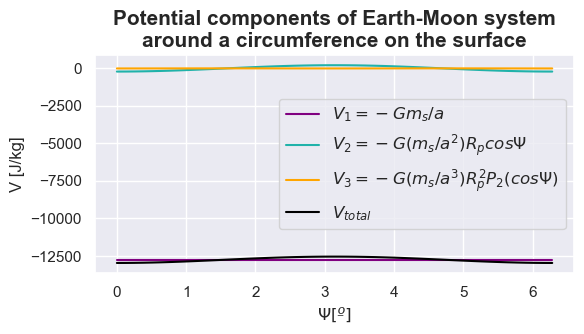

In [65]:
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 1.5})

fig, ax = plt.subplots(figsize=(6, 3.5))

sns.lineplot(x=x_s, y=V_1, ax=ax, color='purple', label='$V_{1} = -Gm_s/a$')
sns.lineplot(x=x_s, y=V_2, ax=ax, color='lightseagreen', label='$V_{2} = -G(m_s/a^2)R_p cos\Psi $')
sns.lineplot(x=x_s, y=V_3, ax=ax, color='orange', label='$V_{3} = -G (m_s/a^3) R_p^2 P_2(cos\Psi)$')
sns.lineplot(x=x_s, y=V_Tot, ax=ax, color='black', label='$V_{total}$')

ax.set_title('Potential components of Earth-Moon system\naround a circumference on the surface', fontdict={'size': 15, 'weight':'bold'})
ax.set_xlabel('$\Psi [º]$')
ax.set_ylabel('V [J/kg]')

ax.legend(loc='best', fontsize=12)
plt.tight_layout()


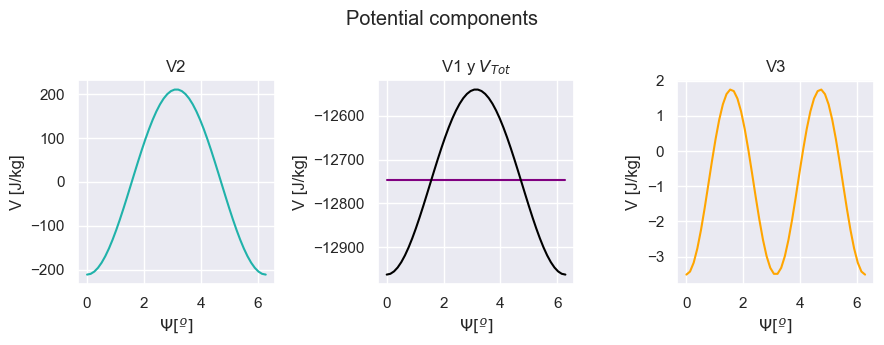

In [66]:
#Looking separetely to identify the variations in different scales:

df = pd.DataFrame({'V2': V_2, 'V1': V_1, 'V3': V_3,'V_total': V_Tot})

fig, axes = plt.subplots(1, 3, figsize=(9, 3.5))
sns.lineplot(x = x_s, y = 'V2', data = df, ax = axes[0], color='lightseagreen')
sns.lineplot(x = x_s, y = 'V3', data = df, ax = axes[2], color='orange')
sns.lineplot(x = x_s, y = 'V1', data = df, ax = axes[1], color='purple')
sns.lineplot(x = x_s, y = 'V_total', data = df, ax = axes[1], color='black')
axes[0].set_title ("V2")
axes[1].set_title("V1 y $V_{Tot}$")
axes[2].set_title("V3")

for ax in axes.flat:
    ax.set(xlabel='$\Psi [º]$', ylabel='V [J/kg]')

plt.suptitle ("Potential components")
plt.tight_layout()
plt.show()

We can prove the relation between $\Psi$ angle and the colatitude and longitude of a point on Earth's surface and a satellite, as shown in figure 4.4 of Murray Dermott's:

<img src="Figures&plots/img_1.png" />

 It can be proved that:

$$\cos \psi=\cos \theta_{\mathrm{P}} \cos \theta_{\mathrm{M}}+\sin \theta_{\mathrm{P}} \sin \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right)$$ **Proof using cosine rule:**



$\begin{aligned} & a^2=p^2+m^2-2 p m \cos \psi \\ & \cos \psi=\frac{a^2-p^2-m^2}{-2 p m} \\ & a^2=\left(x_p-x_m\right)^2+\left(y_p-y_m\right)^2+\left(z_p-z_m\right)^2 \\ & p^2=x p^2+y p^2+z p^2 \\ & m^2=x_m^2+y_m^2+z_m^2 \\ \end{aligned}$

$$cos\Psi = \frac{(x_p-x_m)^2+(y_p-y_m)^2+(z_p-z_m)^2-(x_p^2+y_p^2+z_p^2)^2-(x_m^2+y_m^2+z_m^2)^2}{-2pm}$$
$$cos\Psi = \frac{-2x_p x_m -2y_p y_m -2z_p z_m}{-2pm}$$
$$cos\Psi = \frac{x_p x_m +y_p y_m +z_p z_m}{pm}$$

And since the spherical coordinates of P and M are:

$P = (x_p, y_p, z_p) = (p sen\theta_p cos\Phi_p, p sen\theta_p sen\Phi_p, p cos\theta_p)$

$M = (x_m, y_m, z_m) = (m sen\theta_m cos\Phi_m, m sen\theta_m sen\Phi_m, m cos\theta_m)$

We have:
$$cos\Psi = \frac{(p sen\theta_p cos\Phi_p) (m sen\theta_m cos\Phi_m) + (p sen\theta_p sen\Phi_p) (m sen\theta_m sen\Phi_m) + (p cos\theta_p) (m cos\theta_m)}{pm}$$

$$cos\Psi = cos\theta_p cos\theta_m + sen\theta_p sen\theta_m(cos\Phi_p cos\Phi_m + sen\Phi_p sen\Phi_m)$$

Finally:

$$cos\Psi = cos\theta_p cos\theta_m + sen\theta_p sen\theta_m(cos(\Phi_p-\Phi_m))$$




Hence: $$\begin{aligned} \frac{1}{2}\left(3 \cos ^2 \psi-1\right)= & \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{P}}-1\right) \frac{1}{2}\left(3 \cos ^2 \theta_{\mathrm{M}}-1\right) \\ & +\frac{3}{4} \sin ^2 \theta_{\mathrm{P}} \sin ^2 \theta_{\mathrm{M}} \cos 2\left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) \\  & +\frac{3}{4} \sin 2 \theta_{\mathrm{P}} \sin 2 \theta_{\mathrm{M}} \cos \left(\phi_{\mathrm{P}}-\phi_{\mathrm{M}}\right) .\end{aligned}$$

Let's use a routine to obtain these coordinates from any given point on Earth and and another body. 
For that we're going to need to NAIF kernels imported bellow:

In [67]:
naif_kernels(1)

--2023-05-16 07:59:41--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/pck/earth_200101_990628_predict.bpc
Resolviendo naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Conectando con naif.jpl.nasa.gov (naif.jpl.nasa.gov)[137.78.232.95]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 15121408 (14M)
Grabando a: «earth_200101_990628_predict.bpc»

earth_200101_990628 100%[===================>]  14.42M  9.83MB/s    en 1.5s    

2023-05-16 07:59:44 (9.83 MB/s) - «earth_200101_990628_predict.bpc» guardado [15121408/15121408]

--2023-05-16 07:59:44--  https://naif.jpl.nasa.gov/pub/naif/generic_kernels/lsk/latest_leapseconds.tls
Resolviendo naif.jpl.nasa.gov (naif.jpl.nasa.gov)... 137.78.232.95
Conectando con naif.jpl.nasa.gov (naif.jpl.nasa.gov)[137.78.232.95]:443... conectado.
Petición HTTP enviada, esperando respuesta... 200 OK
Longitud: 5257 (5.1K) [text/plain]
Grabando a: «latest_leapseconds.tls»

latest_leapseconds. 100%[===================>]   

In [68]:
spy.furnsh(["earth_200101_990628_predict.bpc","latest_leapseconds.tls"])  

To use the coordinates from NAIF kernels we must fix a unique reference frame for both objects. It means that we need to convert from Earth fixed rerefence frame to J2000 reference frame:
<img src="Figures&plots/EFCoord.png" width="200" /> to <img src="Figures&plots/J2000RF.png" width="300"/>

Figures from: https://dirsig.cis.rit.edu/

Now we can do it for an specific point on the surface of earth, in this case Medellin city:

In [69]:
#Medellin coordinates
P_ = [-75, 6, 1.4]
M_ = ['Moon', 301]
S_ = ['Sun', 10]
first = Coordinate_transf(P_, M_, "2023-03-07 19:00:00") #first try of transformation

Now that we can use the coordinates of real objects, it is possible to look at the tide raising part of the potential given by: 

$$V_3(\psi)=-\zeta g \mathcal{P}_2(\cos \psi)$$

Where $$\zeta=\frac{m_{\mathrm{s}}}{m_{\mathrm{p}}}\left(\frac{R_{\mathrm{p}}}{a}\right)^3 R_{\mathrm{p}}$$

And $$g=\frac{\mathcal{G} m_{\mathrm{p}}}{R_{\mathrm{p}}^2}$$



In [70]:
#For a hole day in the same point (Medellin) using Time from astropy

start = ['2023-03-07 00:00:00']
tstart = Time(start, format='iso', scale='utc')
stop = ['2023-03-08 00:00:00']
tstp = Time(stop, format='iso', scale='utc')

time = np.linspace(tstart, tstp, 100, endpoint=False)

In [71]:
#Matrix with len(time) rows and 4 columns for the phiP, thetaP, phiS, thetaS
Coords = np.zeros((len(time), 4)) 

for i in range(len(time)):
    #Cicle to transform the coordinates at every given time
    Coords[i] = Coordinate_transf(P_, M_, time[i][0].value)

In [72]:
Phis = np.zeros(len(time))
for i in range(len(time)):
    Phis[i] = cosPsi(Coords[i])
    
Tides = np.zeros(len(time))
for i in range(len(time)):
    Tides[i] = Tide(Phis[i], m_moon, m_earth, R_earth, a_em )

In [73]:
ts = np.array([t.jd for t in time])
ts = ts.reshape((ts.shape[0],))

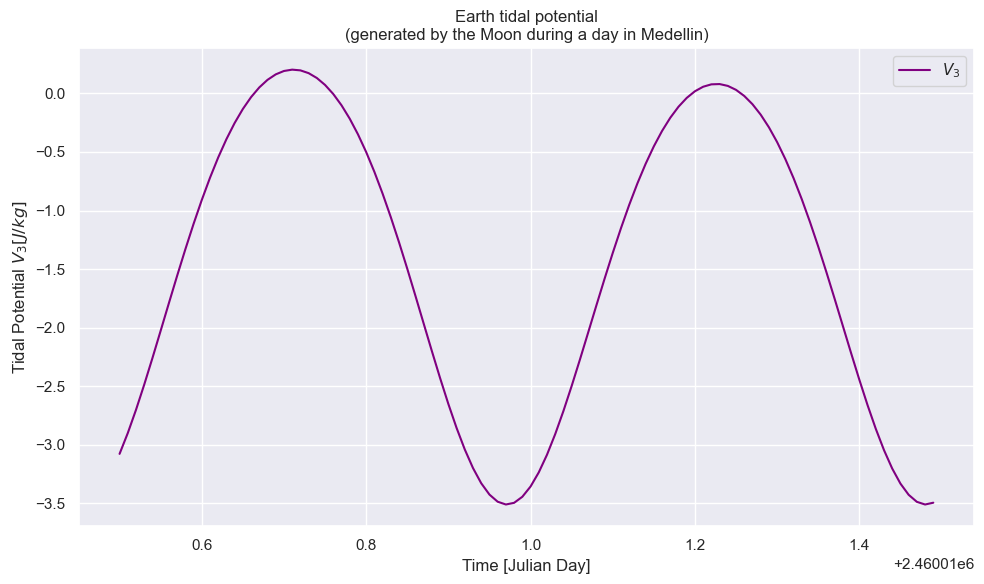

In [74]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=ts, y=Tides, label='$V_3$', c='purple')
plt.xlabel('Time [Julian Day]')
plt.ylabel('Tidal Potential $V_3 [J/kg]$')
plt.title('Earth tidal potential\n(generated by the Moon during a day in Medellin)')
plt.tight_layout()


The graphic shows how the behavior of this part of the potential is, as expected, periodic, and it has two low and two high tides. 

For the tide raised by the Moon on the Earth the amplitude of the equilibrium tide ζ = 0.36 m, while for the solar tide ζ = 0.16 m. 

It would be interesting to look at the equilibrium tide for the jovian system, now considering the satellite as the body experiencing tidal forces produced by Jupiter.
So we could use the equation:


$$\zeta = \frac{m_P}{m_S}\left(\frac{R_S}{a}\right)^3R_S$$

And with some web scrapping from NASA's web, we can obtain the data we need for the galilean satellites:



In [75]:
url = 'https://nssdc.gsfc.nasa.gov/planetary/factsheet/joviansatfact.html'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

table = soup.find('table', {'class': 'bulk'})
if table is None:
    print('Error: The page does not contain the table you are looking for.')
else:
    rows = table.find_all('tr')

data = {'Satellite': [], 'Mass (x10^20 kg)': [],'Radius (km)': [], 'Mean Density (kg/m^3)': [],'Semimajor axis (10^3 km)': []}

for row in rows[3:7]:
    cols = row.find_all('td')
    name = row.find_all('th')
    data['Satellite'].append(name[0].text.strip())
    data['Mass (x10^20 kg)'].append(cols[0].text.strip())
    data['Radius (km)'].append(cols[1].text.strip())
    data['Mean Density (kg/m^3)'].append(cols[2].text.strip())

table = soup.find('table', {'class': 'orbital'})
if table is None:
    print('Error: The page does not contain the table you are looking for.')
else:
    rows = table.find_all('tr')


for row in rows[3:7]:
    cols = row.find_all('td')
    data['Semimajor axis (10^3 km)'].append(cols[0].text.strip())

df = pd.DataFrame(data)
df

,Satellite,Mass (x10^20 kg),Radius (km),Mean Density (kg/m^3),Semimajor axis (10^3 km)
0,Io (I),893.2,1821.5,3530,421.8
1,Europa (II),480.0,1560.8,3010,671.1
2,Ganymede (III),1481.9,2631.2,1940,1070.4
3,Callisto (IV),1075.9,2410.3,1830,1882.7


In [77]:
#Implementation of the function dseta

a_s = df['Semimajor axis (10^3 km)'] #Semimajor axes
m_s = df['Mass (x10^20 kg)'] #Masses of satellites
R_s = df['Radius (km)'] #Satellite's radius

zetas = np.zeros(len(a_s))
for i in range(len(a_s)):
    zetas[i] = dseta(float(R_s[i])*1e3, float(a_s[i])*1e6, m_jup, float(m_s[i])*1e20)
dseta(Rp, a, ms, mp)

In [90]:
#Display the results in a HTML table

data = [df['Satellite'], zetas]
column_titles = ['Satellite', '$\zeta$[m]']

styles = """
table {
  font-family: Arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

th, td {
  border: 1px solid black;
  text-align: center;
  padding: 8px;
}

th {
  background-color: #D3B3C9;
}
"""

html = "<style>{}</style>".format(styles)
html += "<table>"
html += "<tr>"
for title in column_titles:
    html += "<th>{}</th>".format(title)
html += "</tr>"
for row in zip(*data):
    html += "<tr>"
    for cell in row:
        html += "<td class='custom-style'>{}</td>".format(cell)
    html += "</tr>"
html += "</table>"

display(HTML(html))


Satellite,$\zeta$[m]
Io (I),3117.2596556716135
Europa (II),776.4451631198283
Ganymede (III),500.5909106171577
Callisto (IV),89.22649736576476


The equilibrium tide refers to the state where the tidal bulges on the satellites are aligned with the gravitational force exerted by Jupiter. This occurs because the gravitational force pulls on the closest part of Io more strongly than the farther part, resulting in a stretching effect.

However, as you can see in the previous result(in which the deformation would be almost 3 km for Io), the equilibrium tide is a simplified concept and doesn't fully capture the complex tidal interactions between the jovian moons and Jupiter. They experience a combination of tidal forces, including the equilibrium tide, as well as non-equilibrium tides due to their orbital eccentricity and their interaction with other Jovian moons.

Now, going back to Earth, we could look at that difference between amplitudes caused by moon and Sun by plotting in a hole day:

In [91]:
#Same implementation but for the sun 

#Matrix with len(time) rows and 4 columns for the phiP, thetaP, phiS, thetaS
Coords_S = np.zeros((len(time), 4)) 

for i in range(len(time)):
    #Cicle to transform the coordinates at every given time
    Coords_S[i] = Coordinate_transf(P_, S_, time[i][0].value)

Phis_S = np.zeros(len(time))
for i in range(len(time)):
    Phis_S[i] = cosPsi(Coords_S[i])

Tides_Sun = np.zeros(len(time))
for i in range(len(time)):
    Tides_Sun[i] = Tide(Phis_S[i], m_sun, m_earth, R_earth, au )

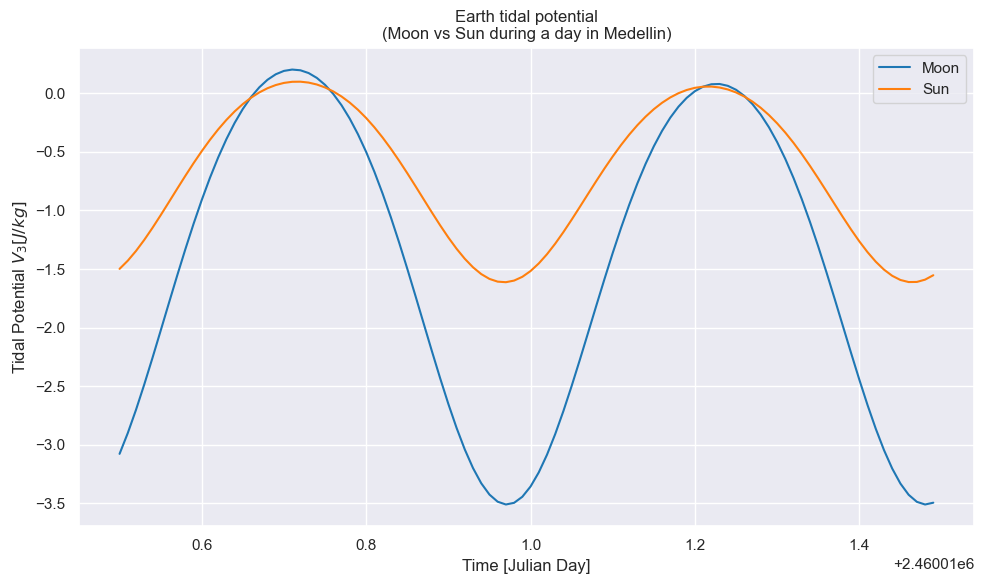

In [92]:
plt.figure(figsize=(10, 6))
sns.lineplot(x=ts, y=Tides, label='Moon')
sns.lineplot(x=ts, y=Tides_Sun, label='Sun')
plt.xlabel('Time [Julian Day]')
plt.ylabel('Tidal Potential $V_3 [J/kg]$')
plt.title('Earth tidal potential\n(Moon vs Sun during a day in Medellin)')
plt.tight_layout()

Then, we confirm that the amplitude of the equilibrium tide for the Sun is smaller than the Moon's in Earth surface. And you could also note the differences in the frequencies of each one, looking at the peaks you can see that the curves are a little bit shifted. 

Now, we could calculate the Earth tides all around the globe at a given time. For that it is necessary to combine the longitude and latitude coordinates:

In [93]:
# Define the longitude and latitude ranges
step = 10
lon_range = np.arange(-180, 180 + step, step)
lat_range = np.arange(-90, 90 + step, step)

# Create a matrix of longitude coordinates repeated for all latitudes
lon_matrix = np.tile(lon_range, (len(lat_range), 1))
print(lon_matrix.shape)


(19, 37)


In [94]:
n, m = lon_matrix.shape

# Initialize an empty array to store the resulting columns
Ps = np.zeros((n*m, 3))

# Use a nested for loop to fill the resulting_columns array
for i in range(m):
    for j in range(n):
        Ps[i*n+j][0] = lon_matrix[j][i]
        Ps[i*n+j][1] = lat_range[j]


Having the coordinates in a single matrix, let's look at the potential around the Earth caused by the Moon at a given time:

In [95]:
#Worldwide coordinates and moon's

M = ['Moon', 301]

#Earth and Moon Coordinates 
E_M_Coordinates = np.zeros((n*m, 4))

for i in range(n*m):
    E_M_Coordinates[i] = Coordinate_transf(Ps[i], M_, "2023-03-07 19:00:00")


In [96]:
Phis = np.zeros(n*m)
for i in range(n*m):
    Phis[i] = cosPsi(E_M_Coordinates[i])
    
Tides = np.zeros(n*m)
for i in range(n*m):
    Tides[i] = Tide(Phis[i], m_moon, m_earth, R_earth, a_em )

In [97]:
data = {
    'latitude': Ps[:,1],
    'longitude': Ps[:,0],
    'potential': Tides
        }
df = pd.DataFrame(data)

To plot the potential in a world map we can use the Geopandas library as is shown bellow:

In [98]:
#Convert the pandas DataFrame into a GeoDataFrame using geopandas.GeoDataFrame() method, and specify the geometry column as a Point object:
from shapely.geometry import Point

gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude))

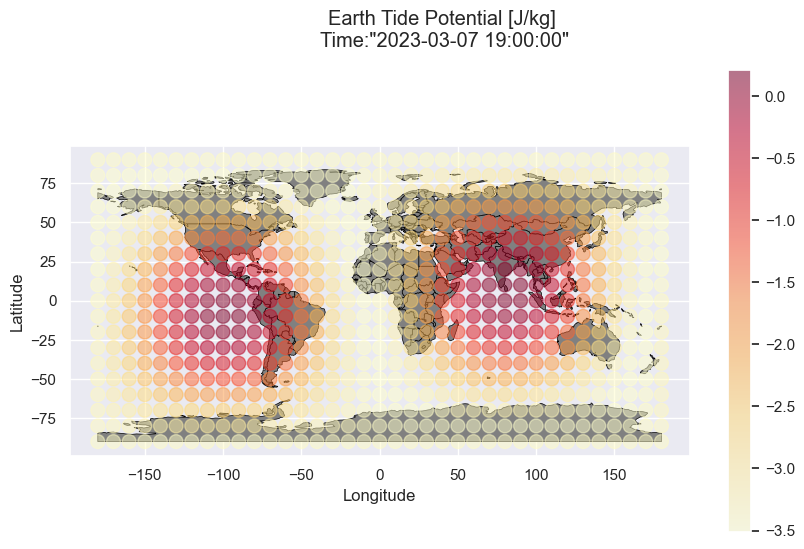

In [99]:
# Load a world map shapefile
world_map = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Create a color map:
cmap = plt.colormaps.get_cmap('YlOrRd')
# Transparency
cmap._init()
cmap._lut[:, -1] = np.linspace(0.5, 0.5, cmap.N+3)

fig, ax = plt.subplots(figsize=(10, 6))
world_map.plot(linewidth=0.5, edgecolor='black', color='grey', ax=ax)

# Plot the coordinates using geopandas.plot() method, and set the column parameter 
    #to the potential column, and the cmap parameter to the color map:
gdf.plot(column='potential', cmap=cmap, markersize=100, ax=ax, legend=True)
fig.suptitle('Earth Tide Potential [J/kg] \nTime:"2023-03-07 19:00:00"')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()


<style>
  /* Style for the h3 element */
  h3 {
    color: #39968E; text-align:center; font-size:30px; letter-spacing:1px;
  font-family:'Brush Script MT', cursive; font-weight:400; 
  }
</style>

<style>
  /* Style for the star symbol */
  .star {
    color: #B7F250; letter-spacing:1px; 
  }
</style>

<h3>What is all that for?</h3>
<p>Earth tides (although not so famous as ocean tides) are crucial in many studies:</p>
<ul style="list-style-type: none; line-height: 1.5;">

<li><span class="star">&#9733;</span> Seismologists have determined that microseismic events are correlated to tidal variations in Central Asia (north of the Himalayas).</li>

<li><span class="star">&#9733;</span> Volcanologists use the regular, predictable Earth tide movements to calibrate and test sensitive volcano deformation monitoring instruments; tides may also trigger volcanic events.</li>

<li><span class="star">&#9733;</span> The semidiurnal amplitude of terrestrial tides can reach about 55 cm at the equator which is important in geodesy using Global Positioning System, very-long-baseline interferometry, and satellite laser ranging measurements.</li>

<li><span class="star">&#9733;</span> Also, to make precise astronomical angular measurements requires accurate knowledge of the Earth's rate of rotation (length of day, precession, in addition to nutation), which is influenced by Earth tides.</li>

<li><span class="star">&#9733;</span> Terrestrial tides also need to be taken in account in the case of some particle physics experiments. For instance, at the CERN or the SLAC National Accelerator Laboratory, the very large particle accelerators were designed while taking terrestrial tides into account for proper operation.</li>
</ul>




### 4.2 Potential Theory 

Zonal Harmonics are used in this section as crucial components of the internal and external potential at a point P, now we have to consider the external and internal potential at this point taking into account the potential produced by the bulge created in the deformed body. 

<img src="Figures&plots/img_2.png" width='500'/>

Zonal harmonics are key in this deduction because they are spherical harmonics of the form $P_l(cos\theta)$, i.e., one which reduces to a Legendre polynomial. It means that we only have dependence on the colatitude $\theta$ because of the axial symmetry of our potential problem. 

Zonal harmonics can be seen as dividing the sphere in zones (as yo can see in the figure bellow), that's why they have that name.
<img src="Figures&plots/m0curves.webp" width='500'/>

Figure from: Physics Forum Insides https://www.physicsforums.com/insights/

In our case we're interested in the second zonal harmonic. One could make a better representation of this spherical harmonic using 3D matplotlib:

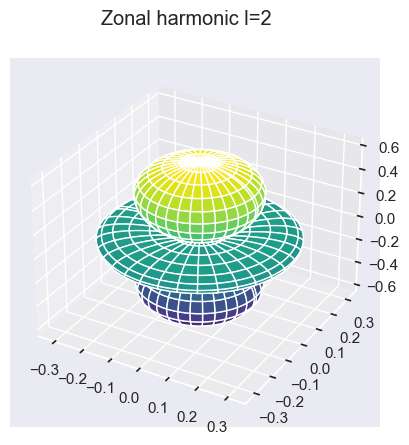

In [100]:
# Degree of the zonal harmonic
l = 2

# Create a mesh grid of theta and phi values
theta, phi = np.mgrid[0:np.pi:101j, 0:2*np.pi:101j]

Y = sph_harm(0, l, phi, theta).real

# Coordinates conversion
x = Y * np.sin(theta) * np.cos(phi)
y = Y * np.sin(theta) * np.sin(phi)
z = Y * np.cos(theta)

# Create a 3D plot of the zonal spherical harmonics 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')
fig.suptitle('Zonal harmonic l=2')
plt.show()


The ortogonality of these harmonics, as seen in the book's discussion,
$$\int_0^{2 \pi} \int_{-1}^{+1} S_n\left(\mu^{\prime}, \phi^{\prime}\right) \mathcal{P}_n(\cos \psi) \mathrm{d} \mu^{\prime} \mathrm{d} \phi^{\prime}=\frac{4 \pi}{2 n+1} S_n(\mu, \phi)$$

is going to help us define the internal and external potential at the point P shown in the first figure of this section. But the book also uses the orthonormality 
$$\int_{-1}^1 P_m(x) P_n(x) d x=\frac{2 \delta_{m n}}{2 n+1}$$

to show that, from both properties, we can obtain:
$$\sum_{n=0}^{\infty}\left(\frac{r}{C}\right)^n \iint \mathcal{P}_2\left(\mu^{\prime}\right) \mathcal{P}_n(\cos \psi) \mathrm{d} \mu^{\prime} \mathrm{d} \phi^{\prime}=\frac{4 \pi}{5}\left(\frac{r}{C}\right)^2 \mathcal{P}_2(\cos \theta)$$

From there, we can finally obtain the potentials that are going to help us in a more robust discussion in the next section:

$$V_{\mathrm{int}}(r, \theta)=-\frac{4}{3} \pi C^3 \gamma \mathcal{G}\left[\frac{3 C^2-r^2}{2 C^3}+\frac{3}{5} \frac{r^2}{C^3} \epsilon_2 \mathcal{P}_2(\cos \theta)\right]$$

$$V_{\mathrm{ext}}(r, \theta)=-\frac{4}{3} \pi C^3 \gamma \mathcal{G}\left[\frac{1}{r}+\frac{3}{5} \frac{C^2}{r^3} \epsilon_2 \mathcal{P}_2(\cos \theta)\right]$$

Now, it could be helpful to take a look to these potentials and how they compare with the potentials that an spherical and non-deformed body would produce:

In [60]:
# Some routines we are going to use:
def v_int(r, theta, C, gamma, epsilon_2):
    r"""
        
    Parameter
    ---------
    
    Returns
    -------
    
    
    Equation
    -------
    :math:`V_3 = \dseta g P_2(cos(\Psi)) `
    """
    f = -4/3*np.pi*C**3*gamma*G*(((3*C**2-r**2)/(2*C**3))+(3*r**2*epsilon_2*P_2(theta))/(5*C**3))
    return f

def v_ext(r, theta, C, gamma, epsilon_2):
    r"""
        
    Parameter
    ---------
    
    Returns
    -------
    
    
    Equation
    -------
    :math:`V_3 = \dseta g P_2(cos(\Psi)) `
    """
    f = -4/3*np.pi*C**3*gamma*G*((1/r)+ (3*C**2*epsilon_2*P_2(theta))/(5*r**3))
    return f


def v_int_homo(r, C, gamma):
    r"""
        
    Parameter
    ---------
    
    Returns
    -------
    
    
    Equation
    -------
    :math:`V_3 = \dseta g P_2(cos(\Psi)) `
    """
    f = -2/3*np.pi*gamma*G*(3*C**2-r**2)
    return f
    
def v_ext_homo(r, C, gamma):
    r"""
        
    Parameter
    ---------
    
    Returns
    -------
    
    
    Equation
    -------
    :math:`V_3 = \dseta g P_2(cos(\Psi)) `
    """
    f = -4/3*np.pi*gamma*G*C**3/r
    return f

We can verify the values of the functions previously defined at some point, for example, in the the surface, both external and internal potential would have to be the same:

In [111]:
#Parameters

C = R_earth #Mean radius
gamma = rho_earth #Mean density
epsilon_2 = 0.01 #Constant
theta = np.pi/2 #Arbitrary angle

print('The potentials at a point at the surface of the deformed ' 
       'body are:\nInternal: ', v_int(C, theta, C, gamma, epsilon_2), 
      '\nExternal: ',v_ext(C, theta, C, gamma, epsilon_2),'\n')

print('The potentials at a point at the surface of the homogeneous ' 
       'body are:\nInternal: ', v_int_homo(C, C, gamma), 
      '\nExternal: ',v_ext_homo(C, C, gamma))

The potentials at a point at the surface of the deformed body are:
Internal:  -62477513.69047482 
External:  -62477513.69047482 

The potentials at a point at the surface of the homogeneous body are:
Internal:  -62665510.22113825 
External:  -62665510.22113824


In [113]:
# Now we could normalize at the values for the surface:

Vsurf = v_int(C, theta, C, gamma, epsilon_2)
Vsurf_hom = v_int_homo(C, C, gamma)

Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.


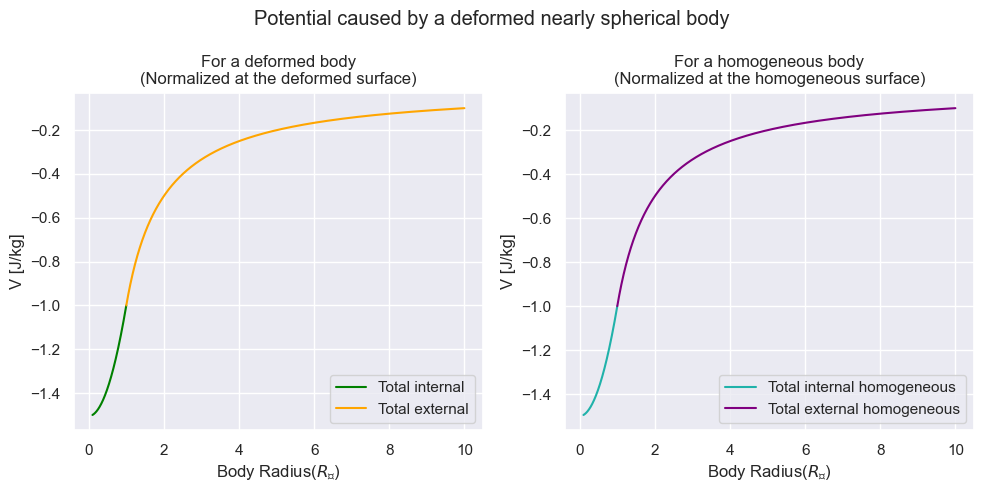

In [118]:
#To calculate the total contribution (of the homogeneous sphere and the mass of deformated body):
Nr = 1000

r_int_s = np.linspace(0.1*R_earth, C, Nr)
r_ext_s = np.linspace(C, 10*R_earth, Nr)
v_int_tot = np.zeros(len(r_int_s))
v_ext_tot = np.zeros(len(r_ext_s))
vint = np.zeros(len(r_int_s))
vext = np.zeros(len(r_ext_s))

for i in range(Nr):
    v_int_tot[i] = v_int(r_int_s[i], theta, C, gamma, epsilon_2)/abs(Vsurf)
    v_ext_tot[i] = v_ext(r_ext_s[i], theta, C, gamma, epsilon_2)/abs(Vsurf)
   
    #Potential at a different r for homogeneous sphere 
    vint[i] = v_int_homo(r_int_s[i], C, gamma)/abs(Vsurf_hom)
    vext[i] = v_ext_homo(r_ext_s[i], C, gamma)/abs(Vsurf_hom)
    
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.lineplot(x=r_int_s/R_earth, y=v_int_tot, ax=axes[0], label='Total internal', color='green')
sns.lineplot(x=r_ext_s/R_earth, y=v_ext_tot, ax=axes[0], label='Total external', color='orange')
sns.lineplot(x=r_int_s/R_earth, y=vint, ax=axes[1], label='Total internal homogeneous', color='lightseagreen')
sns.lineplot(x=r_ext_s/R_earth, y=vext, ax=axes[1], label='Total external homogeneous', color='purple')

axes[0].set_title ("For a deformed body\n(Normalized at the deformed surface)")
axes[1].set_title("For a homogeneous body\n(Normalized at the homogeneous surface)")

for ax in axes.flat:
    ax.set(xlabel='Body Radius($R_🜨$)', ylabel='V [J/kg]')

plt.suptitle ('Potential caused by a deformed nearly spherical body')
plt.tight_layout()
plt.show()

Here we observe the similarity of both potential asumptions, which is the case for our Earth.
To take a better look we could plot the differences between both potentials in the interior and exterior:

Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.
Font 'rm' does not have a glyph for '\U0001f728' [U+1f728], substituting with a dummy symbol.


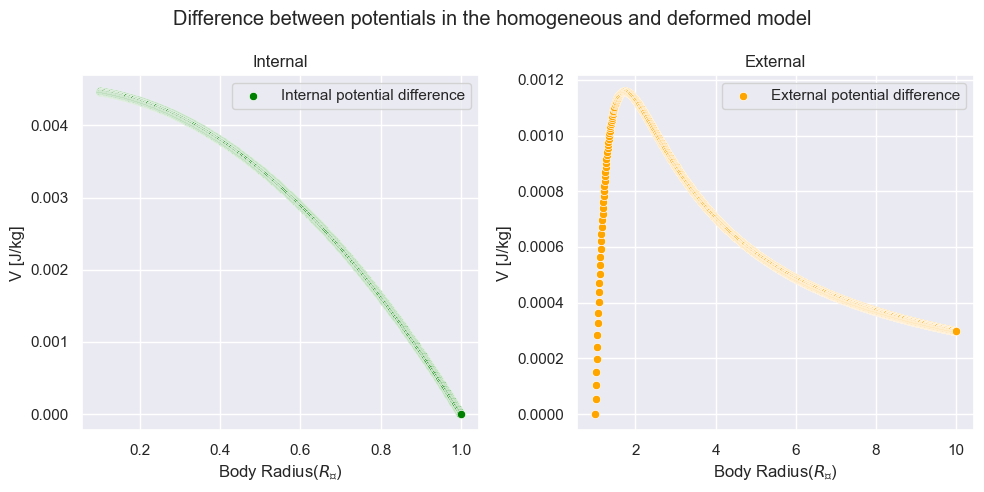

In [133]:
dif_int = np.zeros(Nr)
dif_ext = np.zeros(Nr)
for i in range(Nr):
    dif_int[i] = abs(v_int_tot[i]-vint[i])
    dif_ext[i] = abs(v_ext_tot[i]-vext[i])


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
sns.scatterplot(x=r_int_s/R_earth, y=dif_int, ax=axes[0], label='Internal potential difference', color='green')
sns.scatterplot(x=r_ext_s/R_earth, y=dif_ext, ax=axes[1], label='External potential difference', color='orange')
axes[0].set_title ("Internal")
axes[1].set_title("External")

for ax in axes.flat:
    ax.set(xlabel='Body Radius($R_🜨$)', ylabel='V [J/kg]')

plt.suptitle ('Difference between potentials in the homogeneous and deformed model')
plt.tight_layout()
plt.show()

The result is that for the internal potential the difference (of an order of $10^{-3}$) decreses when reaching the surface. While for the external potentials the difference (of an order of $10^{-4}$) grows rapidly near the surface but as we go far away from the body the difference decreases.

This potential approximation, although for our planet seems to be just a little bit different, it's going to take us to a better description to Earth and ocean tides.

### 4.3 Tidal deformation

Now, we want to make it a little bit more complicated and with the last results, Murray and Dermott make a deduction of the model for a two layer body: almost rigid core and fluid ocean.
In the general case with $\sigma, \rho, \mu, A and B$ as the ocean density, core density, core rigidity, core mean radius and ocean mean radius respectively, the radius of core boundary and ocean surface are going to be deformed and their equations are:

$$R_{\mathrm{cb}}(\psi)=A\left[1+S_2 \mathcal{P}_2(\cos \psi)\right]$$
$$R_{\mathrm{os}}(\psi)=B\left[1+T_2 \mathcal{P}_2(\cos \psi)\right]$$

Were $S_2$ and $T_2$ are constants defined by some conditions on potential and pressure, as you can follow in the book discussion. 

Our porpuse now is to show the geometry of the 2D body in the different cases given by the definition of $S_2$ and $T_2$:

In which we consider the amplitude of the deformation of the core and the ocean as:

$$A S_2=F \frac{(5 / 2) \zeta_{\mathrm{c}}}{1+\tilde{\mu}}$$
$$B T_2=H \frac{5}{2} \zeta$$

Where F and H are the *measure of the effect of the ocean on the amplitude of the core tide* and the *measure of the effect of the internal structure on the external shape of the body*, respectively, and their eqs. are:

$$F=\frac{(1+\tilde{\mu})(1-\sigma / \rho)(1+3 / 2 \alpha)}{1+\tilde{\mu}-\sigma / \rho+(3 \sigma / 2 \rho)(1-\sigma / \rho)-(9 / 4 \alpha)(A / B)^5(1-\sigma / \rho)^2}$$

$$H=\frac{2\langle\rho\rangle}{5 \rho}\left(\frac{1+\tilde{\mu}+(3 / 2)(A / B)^2 F \delta}{(1+\tilde{\mu})(\delta+2 \sigma / 5 \rho)}\right)$$


In [134]:
# Funtions to describe the geometry of the deformed body
def Rcb(S2, Psi, A):
    return A*(1+S2*P_2(np.cos(Psi)))

def Ros(T2, Psi, B):
    return B*(1+T2*P_2(np.cos(Psi)))

def S2_func(A, F, zeta_c, mu_):
    return (F/A)*(5/2)*zeta_c/(1+mu_)

def T2_func(B, H, zeta):
    return (H/B)*(5/2)*zeta

def F_func(mu_, sigma, rho, A, B):
    alpha = 1 + (5/2)*(rho/sigma)*(A/B)**3*(1-sigma/rho)
    return ((1 + mu_)*(1 - sigma/rho)*(1 + 3/(2*alpha)))/(1+mu_-(sigma/rho)+(3*alpha/(2*rho))*(1-(sigma/rho))-(9/(4*alpha))*(A/B)**5*(1-(sigma/rho))**2)

def H_func(mu_, sigma, rho, A, B, F):
    delta = (A/B)**3*(1 - sigma/rho)
    return 2*rho/(5*rho)*((1 + mu_ + (3/2)*(A/B)**2*F*delta)/((1 + mu_)*(delta + 2*sigma/(5*rho))))

In [41]:
# Parameters for Earth
A = 3.483e6 #Mean core radius [m]
B = 6.3781e6 #Mean Ocean radius [m]
rho = 1.2e3 #Mean core density [kg/m^3]
sigma = 1023.6 #Mean ocean density [kg/m]
mu = 5e10 #Core rigidity [N/m^2]
mc = 0.32*m_earth #Core mass [kg]
zeta_c = m_moon/(mc)*(A/a_em)**3*A #Amplitude of the equilibrium tide at core boundary [m]
gc = G*mc/(A**2) #Gravity at core boundary [m/s^2]
mu_ = (19*mu)/(2*rho*gc*A) #Effective rigidity of the core [N/m^2]

zeta = dseta(R_earth, a_em, m_moon, m_earth)
zeta

0.3581768668081791

In [141]:
#Look at the values of S2 and T2 for the Earth in the core-ocean approximation:

#First we need F and H 
F = F_func(mu_, sigma, rho, A, B)
H = H_func(mu_, sigma, rho, A, B, F)
#F, H

S2 = S2_func(A, F_, zeta_c, mu_)
T2 = T2_func(B, H_, zeta)
#S2,T2

print('The values of S2 and T2 for the Earth are: ' 
       'body are:\nS2: ', S2, 
      '\nT2: ',T2,'\n')


The values of S2 and T2 for the Earth are: body are:
S2:  2.3027469288522397e-09 
T2:  1.538501751068773e-07 



In [143]:
## Estos valores son demasiado pequeños.  Y claro el efecto no se nota mucho, excepto si se calculan diferencias
(Rcb(S2_, 0, A)*np.cos(0)-A)*1e3,(Rcb(S2_, 0, A)*np.cos(0)-A)*1e3

(-0.49815233796834946, -0.49815233796834946)

In [155]:
from ipywidgets import interact,fixed,widgets
opciones = dict(continuous_update=False)

def shape(S2=0.1, T2= 0.1, A=3e6, B=6e6): #rho=1.2e3, sigma=1023.6, A=3e6, B=6e6):#
    #F = F_func(mu_, sigma, rho, A, B)
    #H = H_func(mu_, sigma, rho, A, B, F_)
    #S2 = S2_func(A, F_, zeta_c, mu_)
    #T2 = T2_func(B, H_, zeta) 

    x_cb = Rcb(S2, Psi, A)*np.cos(Psi)
    y_cb = Rcb(S2, Psi, A)*np.sin(Psi)
    x_os = Ros(T2, Psi, B)*np.cos(Psi)
    y_os = Ros(T2, Psi, B)*np.sin(Psi)
    
    plt.plot(Rcb(S2, Psi, A)*np.cos(Psi),Rcb(S2, Psi, A)*np.sin(Psi), label='$R_{cb}$ deformed')
    plt.plot(Ros(T2, Psi, B)*np.cos(Psi),Ros(T2, Psi, B)*np.sin(Psi), label='$R_{os}$ deformed')
    plt.plot(A*np.cos(Psi),A*np.sin(Psi), label='Core mean radius A')
    plt.plot(B*np.cos(Psi),B*np.sin(Psi), label='Ocean mean radius B')
    plt.fill_between(Rcb(S2, Psi, A)*np.cos(Psi), Rcb(S2, Psi, A)*np.sin(Psi), color='brown', alpha=0.3, zorder=2)
    plt.fill_between(Ros(T2, Psi, B)*np.cos(Psi), Ros(T2, Psi, B)*np.sin(Psi), color='lightseagreen', alpha=0.3, zorder=1) #, where=mask)
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.legend()
    plt.tight_layout()
    plt.axis('equal')
    plt.show()
    return

# Código de interacción
interact(shape,
         S2 = widgets.FloatSlider(min=0.05,max=0.5,value=0.1,step=0.001,**opciones),
         T2 = widgets.FloatSlider(min=0.05,max=0.5,value=0.1,step=0.001,**opciones),
         
         #rho = widgets.FloatSlider(min=0.5e1,max=2e4,value=1.2e3,step=0.001,**opciones),
         #sigma = widgets.FloatSlider(min=0.5e1,max=2e4,value=1023.6,step=0.001,**opciones),
         A = widgets.FloatSlider(min=2e6,max=4e6,value=3.483e6,step=100,**opciones),
         B = widgets.FloatSlider(min=4e6,max=6e6,value=6.3781e6,step=100,**opciones),
         );


interactive(children=(FloatSlider(value=0.1, continuous_update=False, description='S2', max=0.5, min=0.05, ste…

If we take the limiting case of a planet with a shallow ocean, with the assumptions of $A=B$ and $\zeta_c = \zeta$, the amplitude of the ocean tide would be:

$$A\left(T_2-S_2\right)=\frac{\zeta \tilde{\mu}}{1-\sigma / \rho+\tilde{\mu}(1-3 \sigma / 5 \rho)}$$

And the solid body tide would be:

$$A S_2=\frac{5}{2} \zeta\left[\frac{(1-\sigma / \rho)}{1-\sigma / \rho+\tilde{\mu}(1-3 \sigma / 5 \rho)}\right]$$

As discussed in the book, these last two equations are the best approximation for the Earth, so using them, we can take a new approximation at the tidal deformation of our planet:

In [160]:
#New functions for the deformation of the Earth

def T_2(A, S2, zeta, mu_, sigma, rho):
    return 1/A*(zeta*mu_)/(1-(sigma/rho)+mu_*(1-3*sigma/(5*rho)))

def S_2(A,zeta, mu_, sigma, rho):
    return 5/(2*A)*zeta*(1-(sigma/rho))/(1-(sigma/rho)+mu_*(1-3*sigma/(5*rho)))

def ocean_tide(A, S2, T2):
    return A*(T2-S2)

def body_tide(A, S2):
    return A*S2

In [162]:
#Now the A parameter is going to be the Earth Radius
# Parameters for Earth
A = 6.3781e6 #Mean Earth radius [m]
rho = 1.2e3 #Mean core density [kg/m^3]
sigma = 1023.6 #Mean ocean density [kg/m]
mu = 5e10 #Core rigidity [N/m^2]
mc = 0.32*m_earth #Core mass [kg]
zeta_c = m_moon/(mc)*(A/a_em)**3*A #Amplitude of the equilibrium tide at core boundary [m]
gc = G*mc/(A**2) #Gravity at core boundary [m/s^2]
mu_ = (19*mu)/(2*rho*gc*A) #Effective rigidity of the core [N/m^2]
zeta = dseta(R_earth, a_em, m_moon, m_earth)

S2 = S_2(A,zeta, mu_, sigma, rho)
T2 = T_2(A, S2, zeta, mu_, sigma, rho)

print('The amplitude of the tides for the Earth shallow ocean' 
       ' approximation are:\nOcean deformation: ', ocean_tide(A, S2, T2), 
      '\nBody deformation: ', body_tide(A, S2),'\n')


The amplitude of the tides for the Earth shallow ocean approximation are:
Ocean deformation:  0.7092566567481048 
Body deformation:  0.013417886718930867 



Here we can see the difference from the previous theoretical equilibrium Earth tide, which was 0.3 m. Now we have ocean tides of the same order but the body tides are diminished by the effect of the ocean on the "core" approximation. 

### 4.5 Rotational Deformation
*IDEAS:* 
$\rightarrow$ Construct the oblate spheroid (shape of the distorted planet) using Legendre polynomial of degree 2 where the angle ψ is measured from the axis of symmetry.

$\rightarrow$ Compare the flatness of some planets calculated by the difference between radius and by the realtion with the rotational velocity. (without considering the rotational distortion).

$\rightarrow$ Look at the upper limit on the rotational velocity of the solar system planets and their corresponding rotation period (animation with the spheres and different velocities?).



### 4.6 The Darwin-Radau Relation

$\rightarrow$ Moment of inertia factor (C-) graphic for different planetary systems (if possible). Look at the Darwin–Radau model, and other general core–mantle models.

### 4.7 Shapes and Internal Structures of Satellites

$\rightarrow$ Interactive equipotential surfaces arising from rotational deformation and from tidal deformation.

$\rightarrow$ Which studies have been done in the determination of internal structures using the shape technique described in the text (example of Mimas and Jovian system)? Is it really convenient or other thechniques are being applied nowadays to determine better the shape of planets and satellites?

### 4.8 The Roche Zone 

### 4.9 Tidal Torques

### 4.10 Satellite Tides